In [23]:
import pandas as pd 
import numpy as np
import time
import re
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC,SVR
from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [24]:
# java_stop_words = stopwords.words('english')
stop_words = ['main', 'new', 'subtest','mock','test','public','void','init', 'class', 'name', 'com', 'is', 'prepare','context', 'cli', 'client', 'with', 'www']
# java_stop_words.extend(custom_words)

def clean_words(text):
    res = re.sub(r'\b\W\b', ' ', text)
    return res

def remove_stopwords(text):
    text = str(text).lower().strip()
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
            
    return "".join(tokens)


In [25]:
def remove_comments(text):
    no_comments = re.sub(r'#.*', '', text)
    no_comments = re.sub(r'/\*.*\/\*', '', no_comments)    # comments removal
    no_comments = re.sub(r'\d+','',no_comments)
    no_comments = re.sub(r'_', ' ', no_comments) # _ removeal
    return no_comments

def remove_cammel(text):
    no_cammel = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text)).lower().split()
    return no_cammel

In [26]:
#init dataset
data = pd.read_excel('./flaky_data.xlsx')
df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])
df.drop('project name', axis=1, inplace=True)
df.drop('test case name', axis=1, inplace=True)


#remove comments

df['test case content'] = df['test case content'].apply(lambda x: remove_comments(x))
df['test case content'] = df['test case content'].apply(lambda x: remove_cammel(x))
# df['test case content'] = df['test case content'].apply(lambda x: clean_words(x))
df['tokens'] = df['test case content']



In [27]:
#filter python data and tokenize
java_df = df[df['Language'] == 'Python']
python_df = java_df.reset_index(drop=True)

tokenizer = CountVectorizer(analyzer='word', max_features=1500,stop_words=stop_words)

    
python_df.tokens = python_df.tokens.apply(lambda x: remove_stopwords(x))
bow_token = tokenizer.fit_transform(python_df.tokens)

bow_data = pd.DataFrame(bow_token.toarray(), columns=tokenizer.get_feature_names_out())

#save the vocabulary to extract features on "production"

pickle.dump(tokenizer.vocabulary_, open("./vocabulary/python.dict", 'wb'))


In [28]:
print(list(tokenizer.vocabulary_))

['def', 'get', 'available', 'animations', 'self', 'assert', 'not', 'none', 'handlers', 'motor', 'registers', 'base', 'sounds', 'register', 'goal', 'position', 'range', 'move', 'in', 'direction', 'to', 'left', 'time', 'pause', 'animation', 'audio', 'play', 'welcome', 'hello', 'resume', 'set', 'stop', 'block', 'card', 'all', 'from', 'import', 'id', 'abcd', 'ab', 'result', 'run', 'cmd', 'equal', 'output', 'blocked', 'format', 'requests', 'method', 'response', 'file', 'addresses', 'json', 'einbahnstraße', 'shipping', 'passport', 'legal', 'statements', 'by', 'statement', 'len', 'split', 'api', 'date', 'binary', 'suppresses', 'when', 'terminal', 'httpbin', 'http', 'bytes', 'seed', 'suppressed', 'notice', 'decode', 'but', 'pretty', 'env', 'environment', 'stdin', 'isatty', 'true', 'stdout', 'false', 'included', 'and', 'correct', 'suitable', 'url', 'expected', 'content', 'compress', 'form', 'both', 'post', 'foo', 'bar', 'ok', 'headers', 'encoding', 'deflate', 'data', 'double', 'quiet', 'on', 'e

In [29]:
python_df.drop('tokens', axis=1, inplace=True)
python_df.drop('test case content', axis=1, inplace=True)
python_df.drop('Language', axis=1, inplace=True)
python_df.reset_index()
# java_df.dropna(inplace=True)



,index,label
0,0,Flaky
1,1,Flaky
2,2,Flaky
3,3,Flaky
4,4,Flaky
...,...,...
205,205,NonFlaky
206,206,NonFlaky
207,207,NonFlaky
208,208,NonFlaky


In [30]:

python_df = pd.concat([python_df, bow_data], axis=1)
# java_df = java_df.dropna()
y = python_df['label'].copy()
python_df = python_df.drop('label', axis=1)
x = python_df

In [31]:
# python_df.to_csv('./python_projects.csv', index=False)

In [32]:
# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)


In [33]:
#init classifiers

classifiers = {
    'randomForest': RandomForestClassifier(random_state=1),
    'decisionTree': DecisionTreeClassifier(min_samples_leaf=1),
    'naiveBayes': GaussianNB(),
    'smo': CalibratedClassifierCV(LinearSVC(fit_intercept=False, tol=0.001, C=1, dual=False, max_iter=100000), method='sigmoid'),
    'knn': KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    'logisticRegression': LogisticRegression(max_iter=1000),
    'perceptron': CalibratedClassifierCV(Perceptron()),
    'lda': LinearDiscriminantAnalysis(),
}

In [34]:
def save_incorrect_classifications(x_test, predicted, label, classifier):
    label = label.to_frame(name='labeltestclass').reset_index()
    predicted = pd.DataFrame(predicted, columns=['predictedclass']).reset_index()
    
    df = pd.DataFrame(x_test).reset_index()
    df['labeltestclass'] = label.reset_index()['labeltestclass']
    df['predictedclass'] = predicted.reset_index()['predictedclass']
    
    df[df.predictedclass != df.labeltestclass].to_csv("./IC/"+classifier+"_IC.txt")


def round_float(value):
    return float("{:.3f}".format(value))


def get_time(start_time):
    end_time = time.time()
    return end_time - start_time


def plot_learning_curve(estimator, name, title, x,y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(30, 7))
        
    axes[0].set_title(title)
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
        
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.mean(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color='r')
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color='g')
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    
    # plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    
    #plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    fig.savefig('./plot' + name + '.png')            
    

In [35]:
def plot_comparison(comparison_values):
    
    comp = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    for key, classifier in comparison_values.items():
        fraction_of_positives, mean_predicted_value = calibration_curve(classifier['y_test'], classifier['y_probs'], n_bins=10)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % (key))
        ax2.hist(classifier['y_probs'], range=(0, 1), bins=10, label=key, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')        

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    comp.tight_layout()
    
    comp.savefig('./plot/compare.png')

In [36]:
def classify(x_train, x_test, y_train, y_test, classifiers, normalize=[], plot=True):
    
    labels = ['Flaky', 'NonFlaky']
    results = pd.DataFrame()
    
    comparison_values = {}
    
    # create a normalized version
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    
    for key, classifier in classifiers.items():
        
        x_train_exec = x_train 
        x_test_exec = x_test
        y_train_exec = y_train
        y_test_exec = y_test
        
        if (key in normalize):
            x_train_exec = x_train_norm
            x_test_exec = x_test_exec
        
        classifier.fit(x_train_exec, y_train)
        classifier.score(x_test_exec, y_test)
        
        predict = classifier.predict(x_test_exec)
        y_probs = classifier.predict_proba(x_test_exec)[:,1]
        
        save_incorrect_classifications(x_test_exec, predict, y_test, key)
        
        result = {
            'classifier': key,
            'f1score': f1_score(y_test, predict, average='weighted'),
            'accuracy': classifier.score(x_test_exec, y_test),
            'confusionMatrix': confusion_matrix(y_test, predict),
            'execution': round_float(get_time(start_time)),
            'classificationReport': classification_report(y_test, predict, output_dict=True),
            'AUC': roc_auc_score(y_test, y_probs),
            'MCC': matthews_corrcoef(y_test, predict),
            
        }
        # results = pd.concat([results, result], ignore_index=True)
        results = results._append(result, ignore_index=True)
        
        
        if (plot):
            plot_learning_curve(classifier, key, key, x_train_exec, y_train, ylim=(0.5, 1.01), n_jobs=4)
            
            comparison_values[key] = {
                'y_test': y_test,
                'Y_probs': y_probs
            }

        
        print(key, classification_report(y_test, predict, output_dict=True)['Flaky'], matthews_corrcoef(y_test, predict), roc_auc_score(y_test, y_probs), "\n \n")

        res = [key, classification_report(y_test, predict, output_dict=True)['Flaky'], matthews_corrcoef(y_test, predict), roc_auc_score(y_test, y_probs)]
        classifications = classification_report(y_test, predict, output_dict=True)['Flaky']
    

    
    return results, res, classifications

In [37]:
from sklearn.feature_selection import RFE
def feature_ranking (X, y): 

    estimator = RandomForestClassifier(max_depth=5, random_state=3)
    selector = RFE(estimator, n_features_to_select = 20, step=5).fit_transform(X, y)

    selector = selector.fit(X, y)

    return selector.ranking_,selector.score(X, y), selector.n_features_, selector.support_

def feature_importance(x, y):
    
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    estimator = RandomForestClassifier()
    estimator.fit(x, y)
    importance = estimator.feature_importances_
    
    return importance

randomForest {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28.0} 1.0 1.0 
 

decisionTree {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28.0} 1.0 1.0 
 

naiveBayes {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 28.0} 0.816496580927726 0.9285714285714286 
 

smo {'precision': 1.0, 'recall': 0.9642857142857143, 'f1-score': 0.9818181818181818, 'support': 28.0} 0.9486832980505139 0.9974489795918368 
 



/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


knn {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28.0} 1.0 1.0 
 

logisticRegression {'precision': 1.0, 'recall': 0.9642857142857143, 'f1-score': 0.9818181818181818, 'support': 28.0} 0.9486832980505139 1.0 
 

perceptron {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28.0} 1.0 1.0 
 

lda {'precision': 0.9615384615384616, 'recall': 0.8928571428571429, 'f1-score': 0.9259259259259259, 'support': 28.0} 0.7973815320737668 0.923469387755102 
 



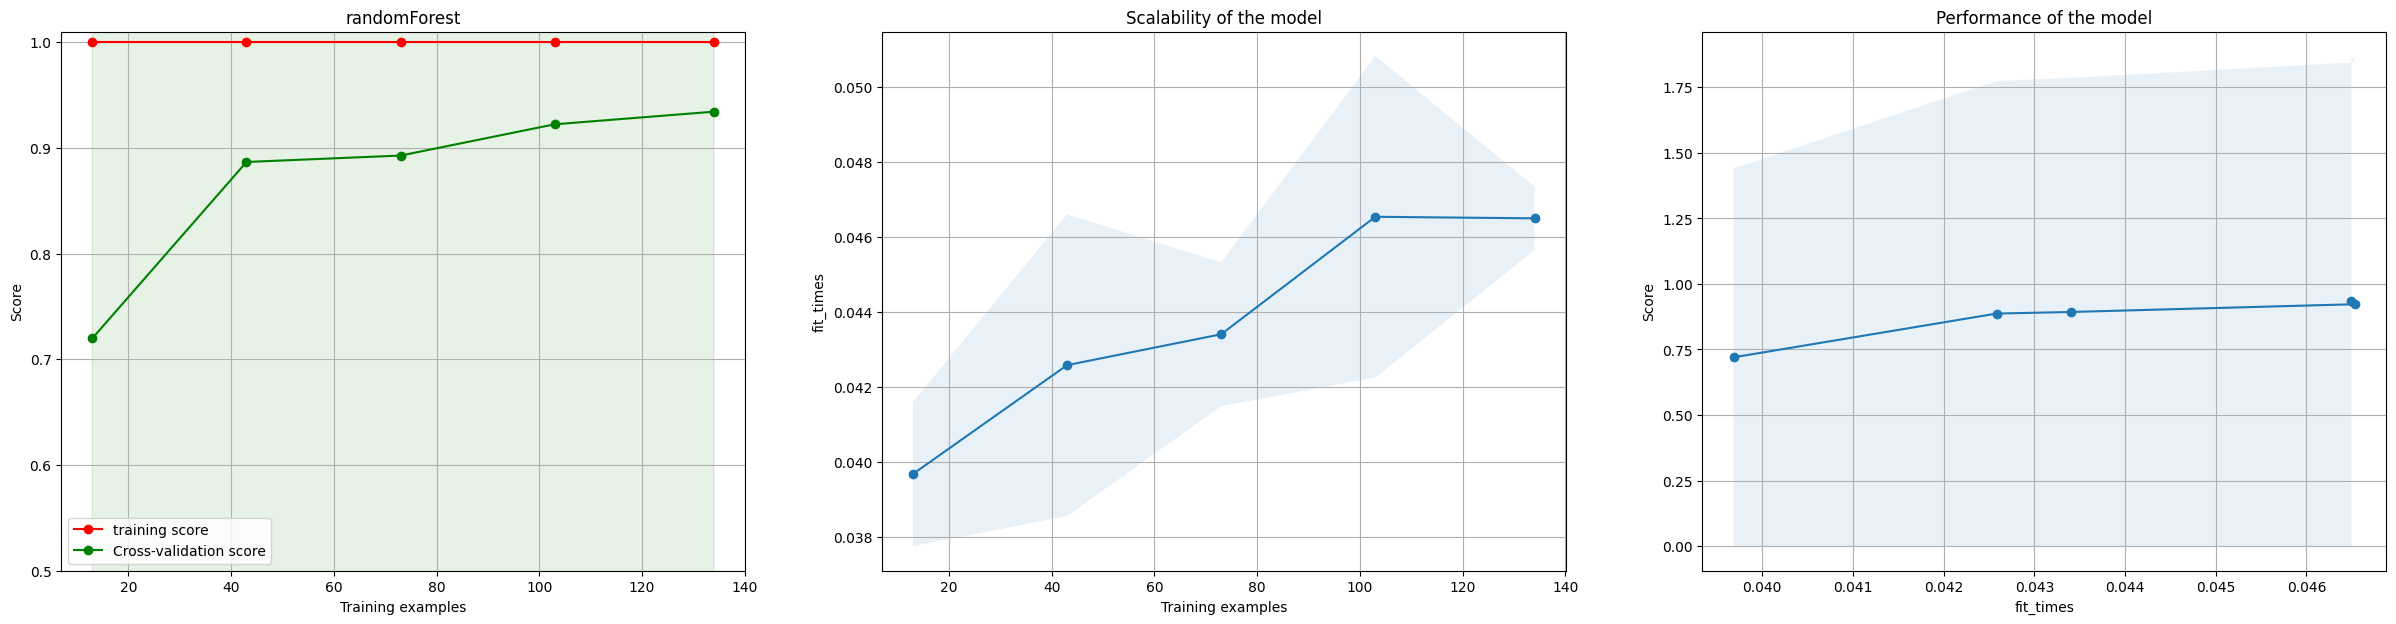

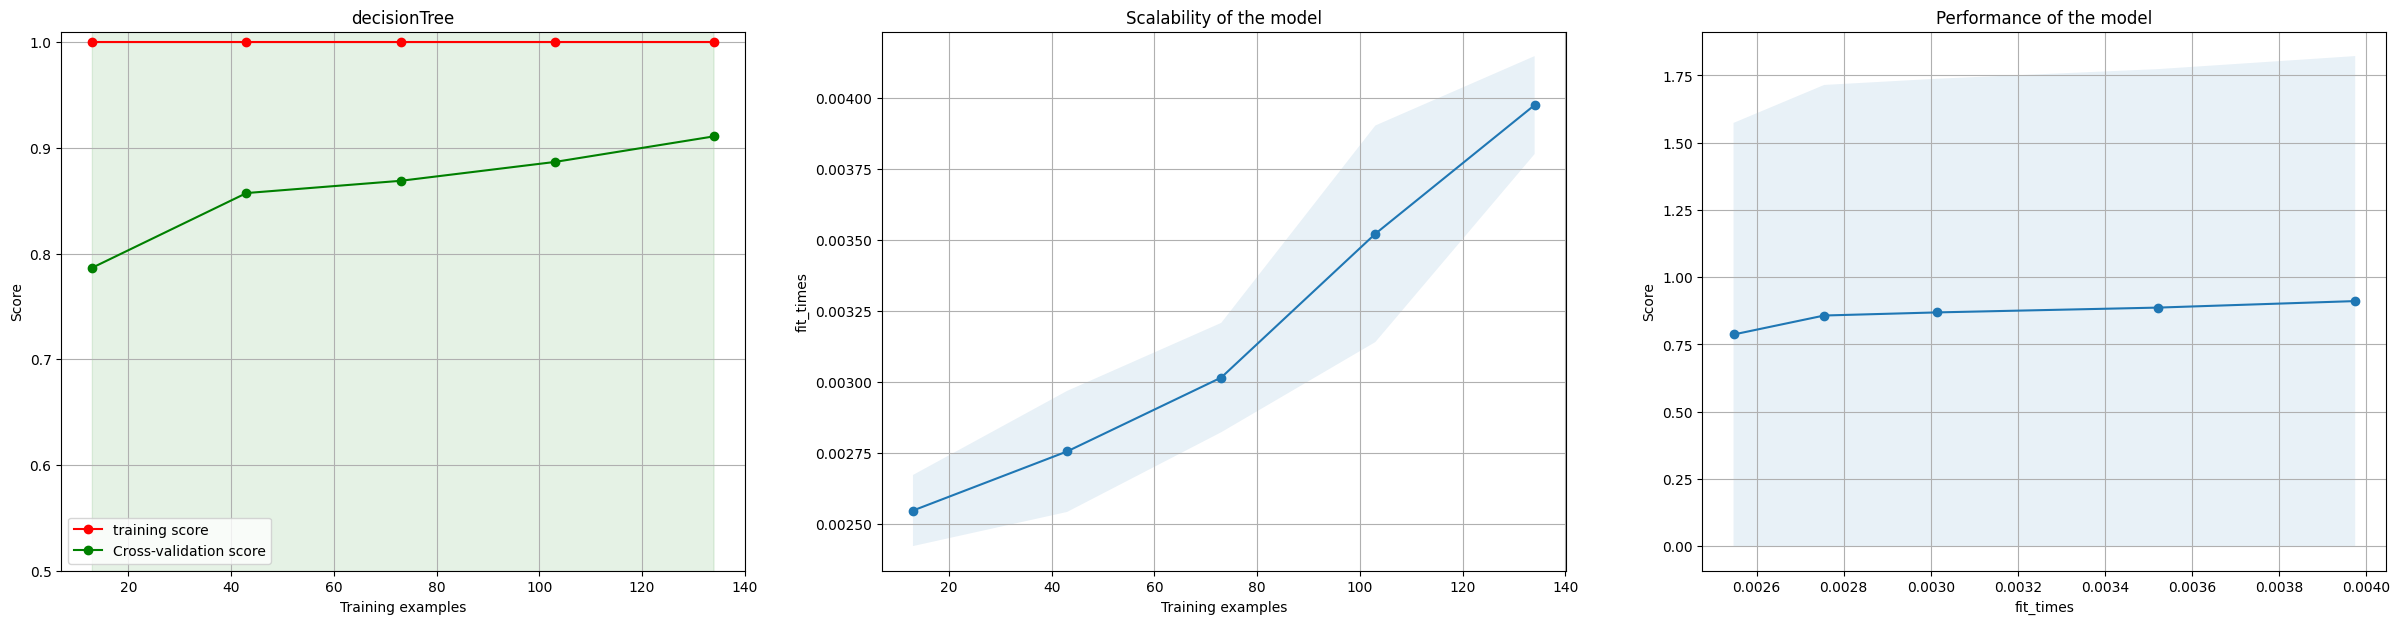

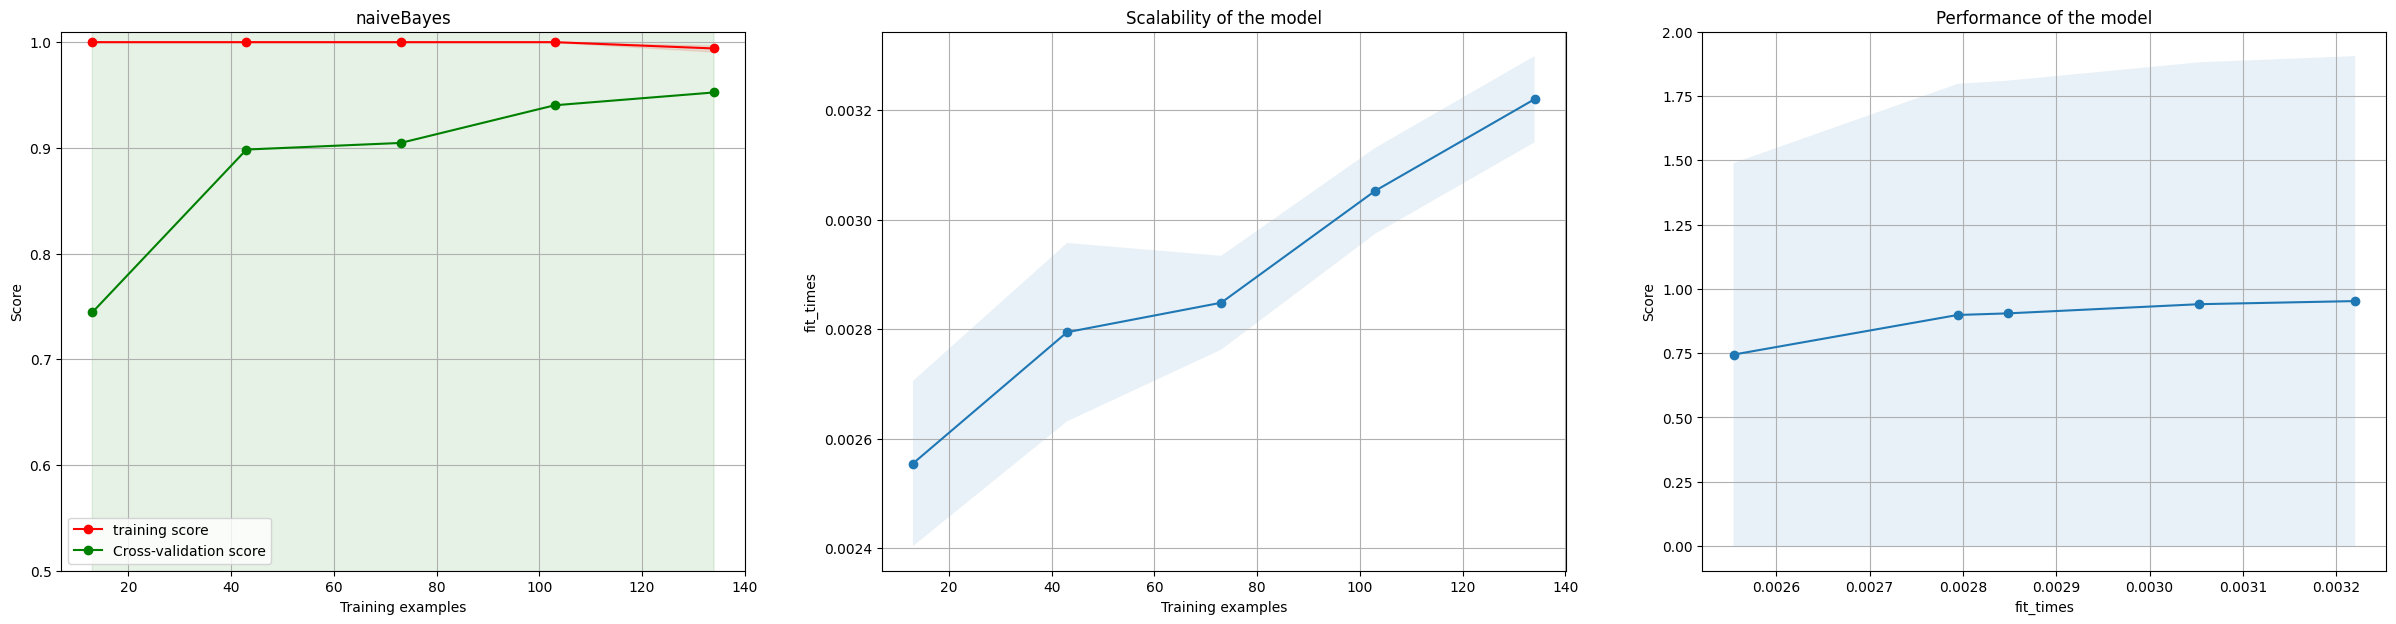

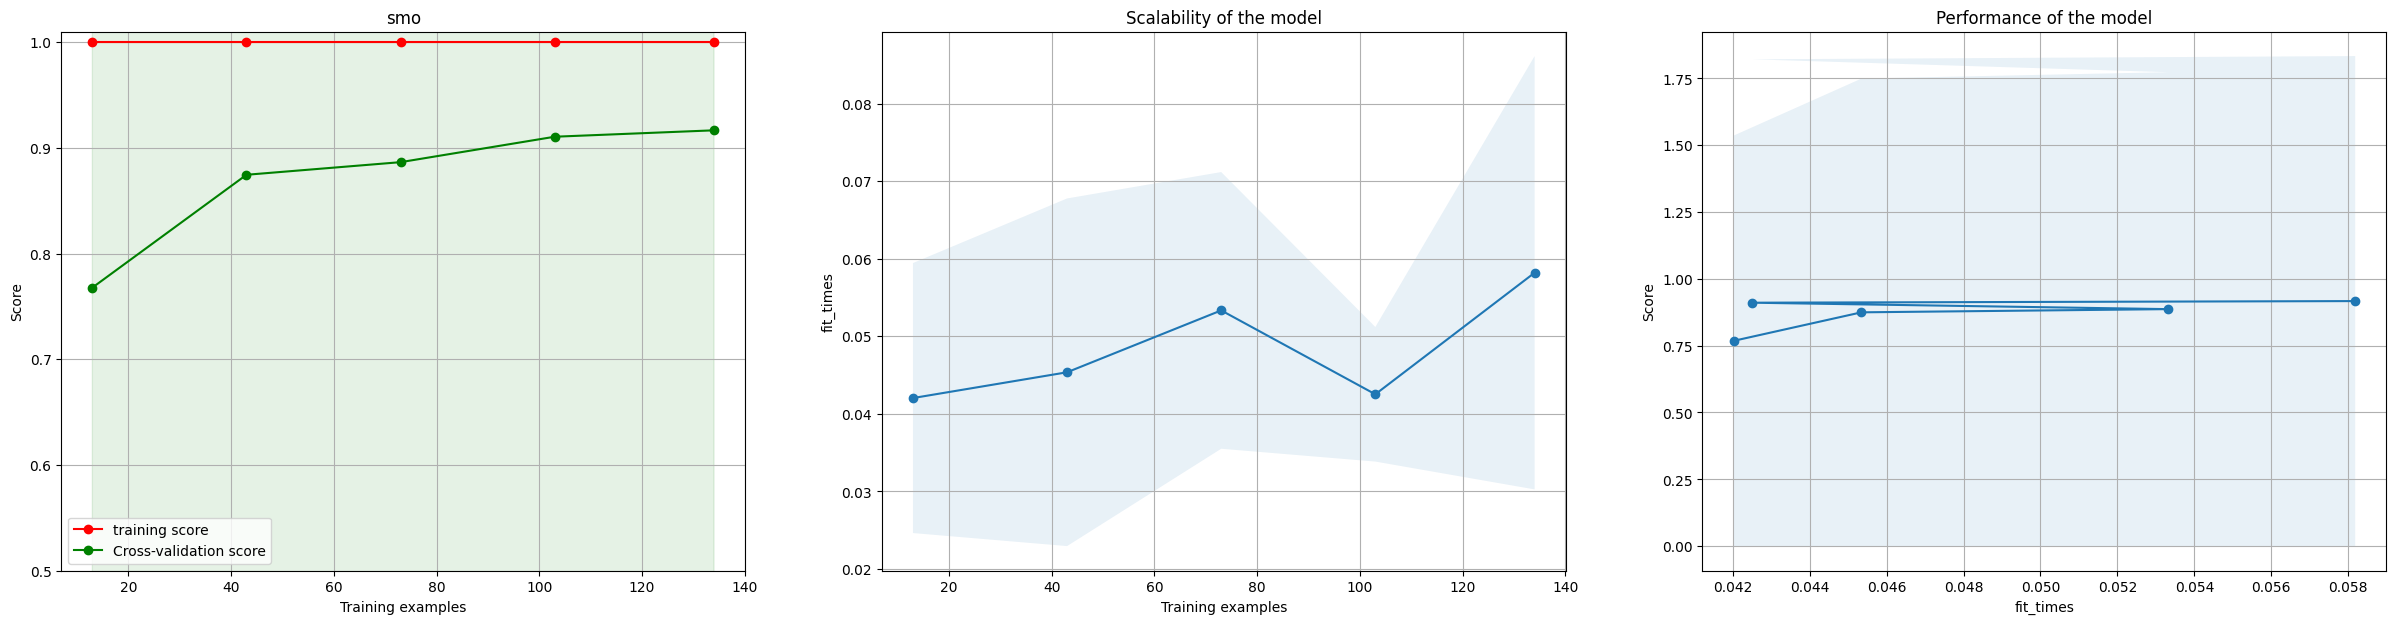

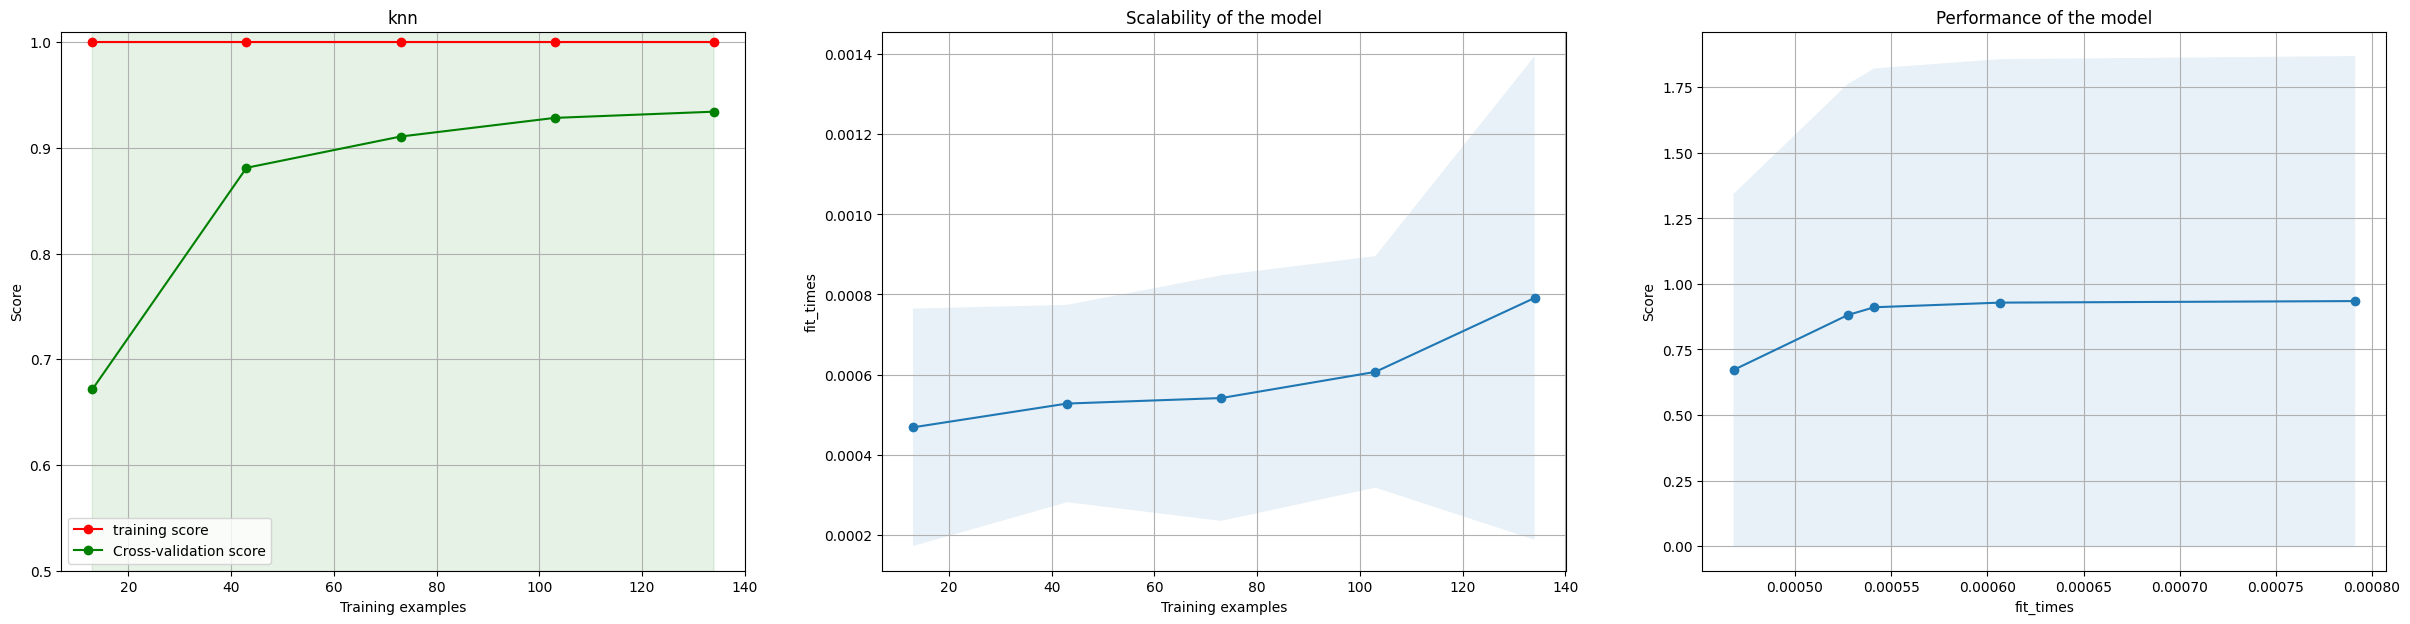

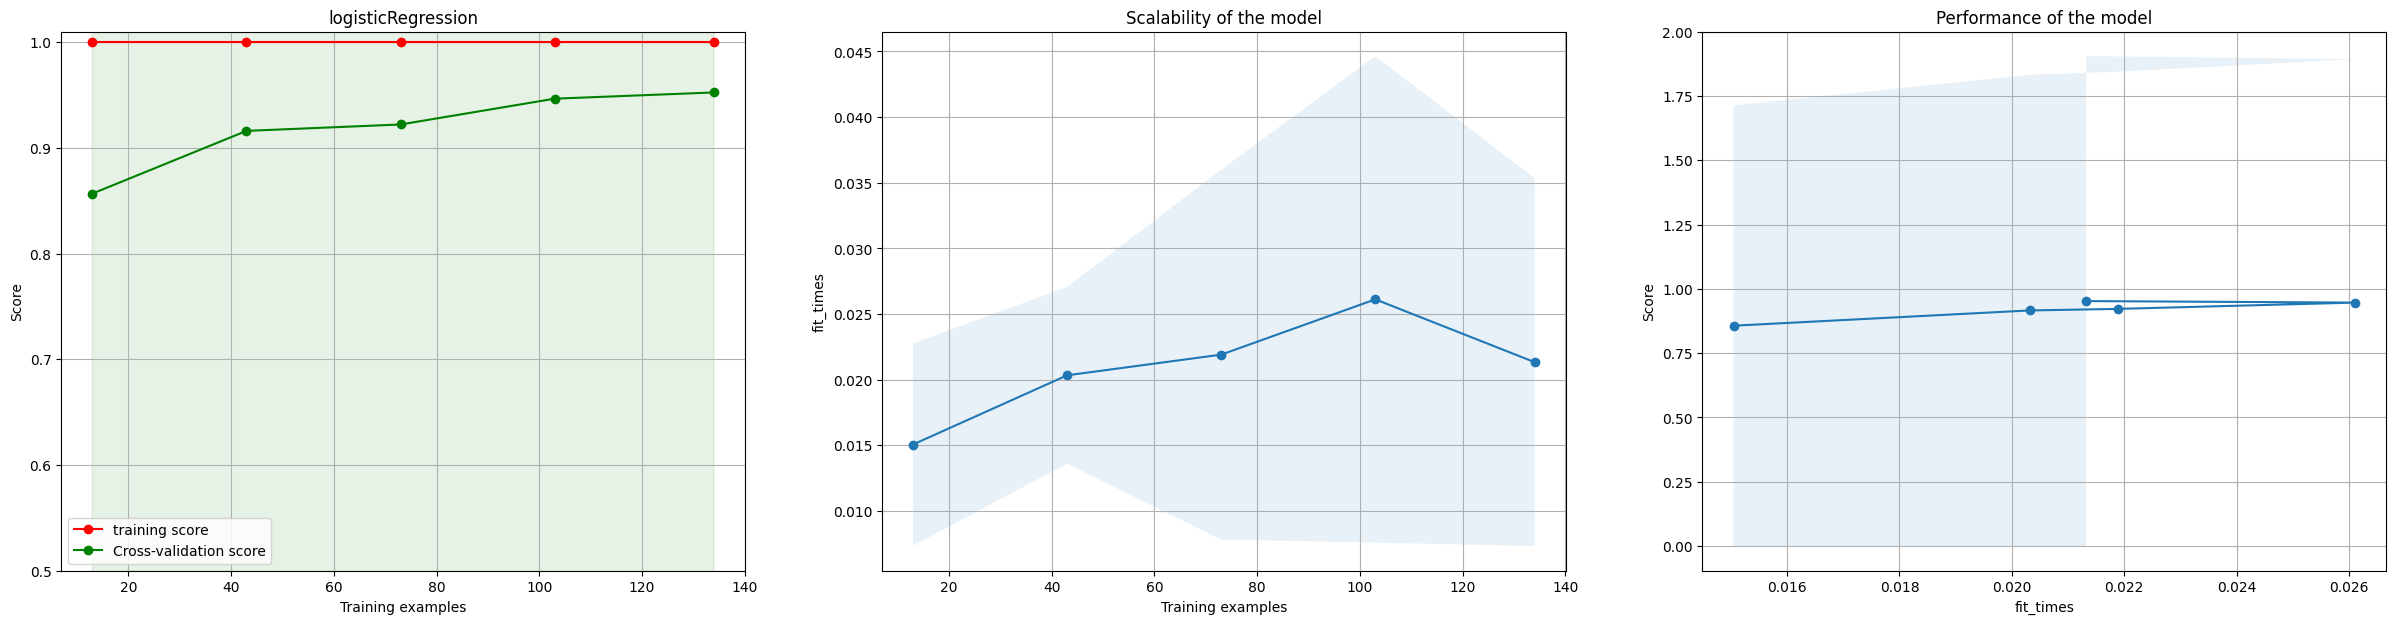

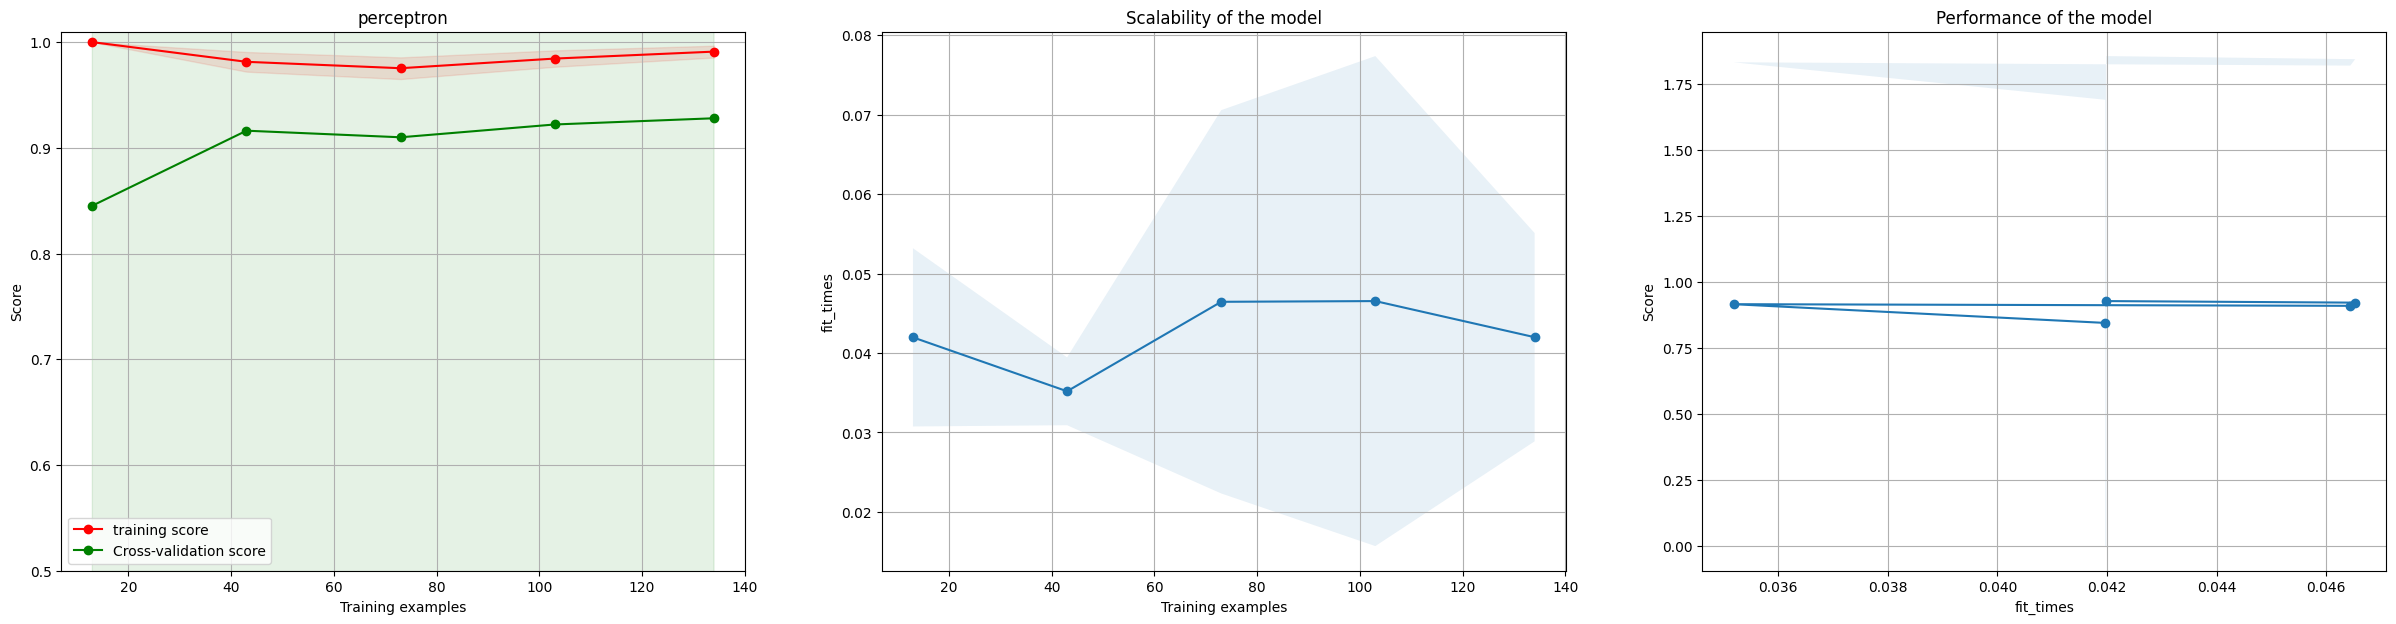

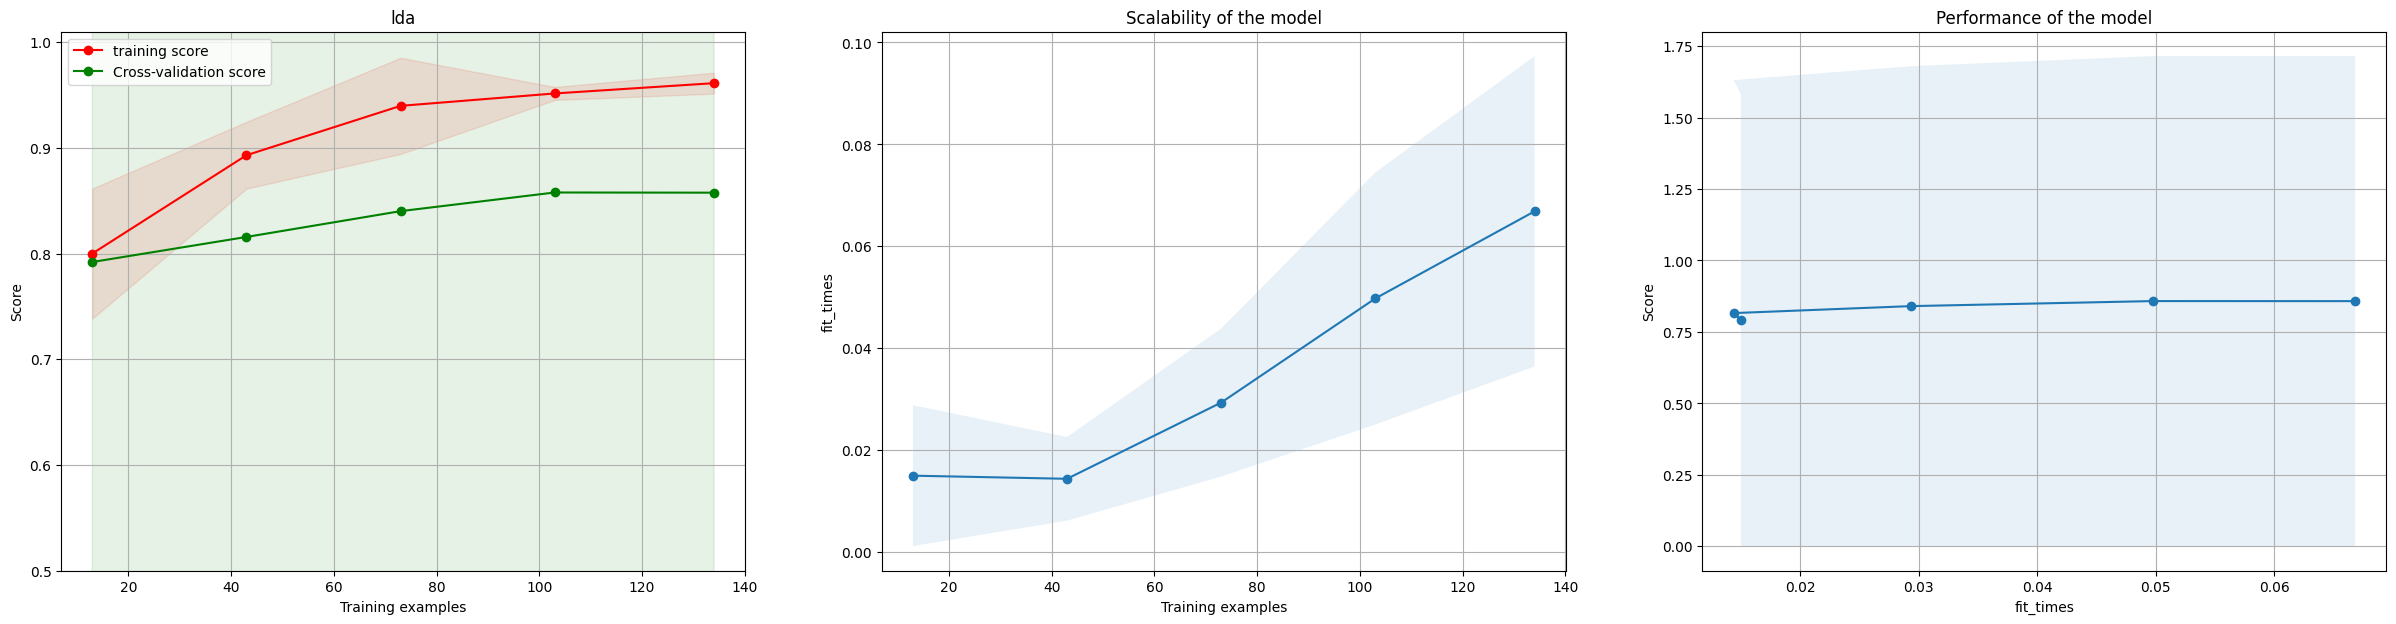

In [38]:
start_time = 0
results, res, classification_report = classify(x_train, x_test, y_train, y_test, classifiers, normalize=['knn'])




In [39]:
# y_train[y_train == 'Flaky'] = 1
# y_train[y_train == 'NonFlaky'] = 0
# rank, scores, nfeatures,supp = feature_ranking(x_train, y_train)

In [40]:
importance = feature_importance(x_train, y_train)

In [41]:
print("The top 20 features in Python Projects are:\n", x_train.columns[np.argsort(-importance)[:20]])

The top 20 features in Python Projects are:
 Index(['model', 'err', 'self', 'check', 'app', 'equal', 'flask', 'true',
       'msgs', 'assert', 'instance', 'https', 'msg', 'process', 'dict', 'text',
       'if', 'and', 'batch', 'config'],
      dtype='object')


In [42]:
print(classification_report)

{'precision': 0.9615384615384616, 'recall': 0.8928571428571429, 'f1-score': 0.9259259259259259, 'support': 28.0}


In [43]:
print(results.confusionMatrix)

0    [[28, 0], [0, 14]]
1    [[28, 0], [0, 14]]
2    [[24, 4], [0, 14]]
3    [[27, 1], [0, 14]]
4    [[28, 0], [0, 14]]
5    [[27, 1], [0, 14]]
6    [[28, 0], [0, 14]]
7    [[25, 3], [1, 13]]
Name: confusionMatrix, dtype: object


In [44]:
results.to_excel('./python_results.xlsx', index=False)